# Covolutional Neural Networks

## Import Related Libraries

In [2]:
import os
import random
from glob import glob
import shutil
import itertools

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, BatchNormalization 
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import f1_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Setup the GPU configuration
- `ImageDataGenerator` doesn't work with TPU. So, we're going to configur GPU, instead.

In [3]:
pyshical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"List of GPUs Available: {len(pyshical_devices)}")
tf.config.experimental.set_memory_growth(pyshical_devices[0],True)

List of GPUs Available: 1


## Data Preparation

The images included in the data/cats-and-dogs directoy are random subset of the full cat and dog dataset from the following Kaggle competition: https://www.kaggle.com/c/dogs-vs-cats/data



### Prepare samples for each files

In [ ]:
# Select the operation directory
fpath = "/content/drive/MyDrive/Colab Notebooks/Deep_Learning/cats-dogs-dataset"
# Move to the operation directory
os.chdir(fpath)
# Organize data into train, validation, test datasets
if os.path.isdir("train/cats") is False:
  # Create a dir file for cats to include our datasets:
  os.makedirs("train/cats")
  os.makedirs("valid/cats")
  os.makedirs("test/cats")

  # Create a dir file for dogs to include our datasets:
  os.makedirs("train/dogs")
  os.makedirs("valid/dogs")
  os.makedirs("test/dogs")
  
  # Move the data randomly to each folder
  ## Train data for cats is 70%
  for each in random.sample(glob('cat*'), 8750):
    shutil.move(each, "train/cats")
  
  ## Validation data for cats is 10%
  for each in random.sample(glob('cat*'), 1250):
    shutil.move(each, "valid/cats")
  
  ## test data for cats is 20%
  for each in random.sample(glob('cat*'), 2500):
    shutil.move(each, "test/cats")
  # ------------------------------------------------------
  ## Train data for dogs is 70%
  for each in random.sample(glob('dog*'), 8750):
    shutil.move(each, "train/dogs")
  
  ## Validation data for dogs is 10%
  for each in random.sample(glob('dog*'), 1250):
    shutil.move(each, "valid/dogs")
  
  ## test data for dogs is 20%
  for each in random.sample(glob('dog*'), 2500):
    shutil.move(each, "test/dogs")

os.chdir('../../')

## Data Pre-processing (Image Pre-processing)

### Data Wrangling

In this preprocessing, we will going to explain how to image preprocessing is implemented with tensorflow.

1. We're going to use [ImageDataGenerator](https://keras.io/api/preprocessing/image/) for preprocessing the images and convert them into tensors.

2. For converting the image to tensor, we need to use one of Keras applications called [VGG116](https://keras.io/api/applications/vgg/). 
  - For VGG16, call `For VGG16, call tf.keras.applications.vgg16.preprocess_input` before sending the input of these images into the model.
  
  - This application allows us to convert the RGB images into BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

In [5]:
# Check the directories
fpath = "/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Animal_detection/cats-dogs-dataset"
# Move to the operation directory
os.chdir(fpath)
print(len(glob('train/dogs/dog*')))
print(len(glob('valid/cats/cat*')))
print(len(glob('test/dogs/dog*')))
print(os.path.abspath("train/dogs"))

8750
1250
2500
/content/drive/My Drive/Colab Notebooks/Deep_Learning/Animal_detection/cats-dogs-dataset/train/dogs


In [6]:
# Let's link each folder to a variable
train_path = os.path.abspath('train')
valid_path = os.path.abspath('valid')
test_path = os.path.abspath('test')

In [7]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
              .flow_from_directory(directory=train_path, target_size=(224, 224), classes=['cats', 'dogs'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
              .flow_from_directory(directory=valid_path, target_size=(224, 224), classes=['cats', 'dogs'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
              .flow_from_directory(directory=test_path, target_size=(224, 224), classes=['cats', 'dogs'], batch_size=10, shuffle=False)

Found 17500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [8]:
# Test our data
assert train_batches.n == 17500
assert valid_batches.n == 2500
assert test_batches.n == 5000
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

### Exploratory Data Analysis

After validating the data we have, let's explore our data by ploting the data and see the lables of the images

In [10]:
imgs, labels = next(train_batches) # we're getting 1 of the batch to plot it and see the data how it looks like

In [9]:
# This function from tensorflow website to plot the data
def PlotImages(img_array):
  fig, axes = plt.subplots(1, 10, figsize=(20,20)) # This will allows us to put the images we have into sort of tuple
  axes = axes.flatten() # flatten the tuple to have all the images
  for img, ax in zip(img_array, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

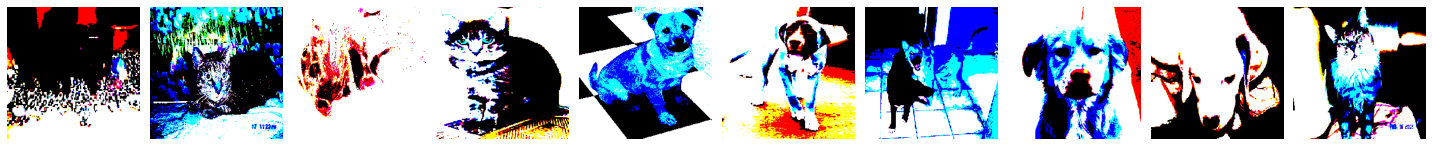

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [ ]:
PlotImages(imgs)
print(labels)

## Train Test split

This phase has already implemented in the data preparation.

## Algorithm Setup

In [ ]:
model = Sequential([
                    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(224,224,3)),
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Flatten(),
                    Dense(units=2, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
________________________________________________

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=['accuracy'])

## Model Fitting

In [ ]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
1750/1750 - 93s - loss: 0.0176 - accuracy: 0.9950 - val_loss: 2.6755 - val_accuracy: 0.7184
Epoch 2/10
1750/1750 - 92s - loss: 0.0215 - accuracy: 0.9937 - val_loss: 2.7293 - val_accuracy: 0.7224
Epoch 3/10
1750/1750 - 93s - loss: 0.0150 - accuracy: 0.9955 - val_loss: 2.7374 - val_accuracy: 0.7172
Epoch 4/10
1750/1750 - 92s - loss: 0.0183 - accuracy: 0.9937 - val_loss: 2.7501 - val_accuracy: 0.7260
Epoch 5/10
1750/1750 - 93s - loss: 0.0237 - accuracy: 0.9934 - val_loss: 3.2654 - val_accuracy: 0.7216
Epoch 6/10
1750/1750 - 94s - loss: 0.0217 - accuracy: 0.9937 - val_loss: 3.2737 - val_accuracy: 0.7128
Epoch 7/10
1750/1750 - 93s - loss: 0.0195 - accuracy: 0.9949 - val_loss: 3.3863 - val_accuracy: 0.7212
Epoch 8/10
1750/1750 - 94s - loss: 0.0193 - accuracy: 0.9945 - val_loss: 3.2549 - val_accuracy: 0.7228
Epoch 9/10
1750/1750 - 94s - loss: 0.0215 - accuracy: 0.9941 - val_loss: 3.2643 - val_accuracy: 0.7116
Epoch 10/10
1750/1750 - 93s - loss: 0.0152 - accuracy: 0.9957 - val_loss:

## Predict Model

In [ ]:
img, labels = next(test_batches)

In [ ]:
# Check the classes
test_batches.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

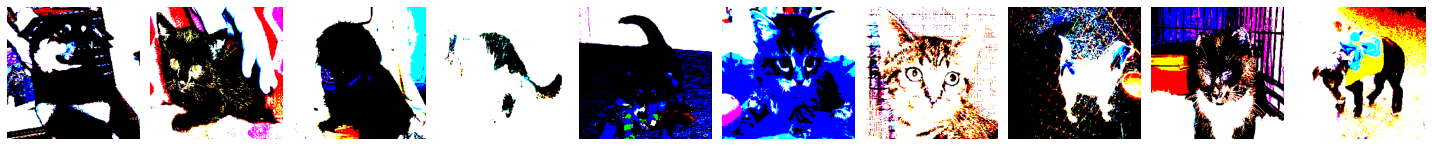

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [ ]:
PlotImages(img)
print(labels)

In [ ]:
pred = model.predict(x=test_batches, verbose=2)

500/500 - 1354s


In [ ]:
pred[:5]

array([[1.3804312e-01, 8.6195695e-01],
       [9.9999964e-01, 3.0534667e-07],
       [6.9817615e-01, 3.0182388e-01],
       [4.3633896e-08, 1.0000000e+00],
       [2.3856461e-02, 9.7614360e-01]], dtype=float32)

## Evaluation

Let's round our prediction

In [ ]:
np.round(pred)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
classification_report(y_true=test_batches.classes, y_pred=np.argmax(pred, axis=-1))

'              precision    recall  f1-score   support\n\n           0       0.51      0.48      0.49      2500\n           1       0.51      0.54      0.52      2500\n\n    accuracy                           0.51      5000\n   macro avg       0.51      0.51      0.51      5000\nweighted avg       0.51      0.51      0.51      5000\n'

**Why do we use `numpy.argmax()` to return an index from a numpy array of predictions?**

> What any classification neural network outputs is a probability distribution over the class indices, meaning that the network assigns one probability to each class. The sum of these probabilities is 1.0. Then the network is trained to assign the highest probability to the correct class, so to recover the class index from the probabilities you have to take the location (index) that has the maximum probability. This is done with the argmax operation. [Ref. Stackoverflow](https://stackoverflow.com/questions/56382596/why-do-we-use-numpy-argmax-to-return-an-index-from-a-numpy-array-of-prediction)



In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(pred, axis=-1))

In [ ]:
f1_score(y_true= test_batches.classes, y_pred=np.argmax(pred, axis=-1), labels=[0, 1])

0.5208090237261765

In [33]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1197 1303]
 [1161 1339]]


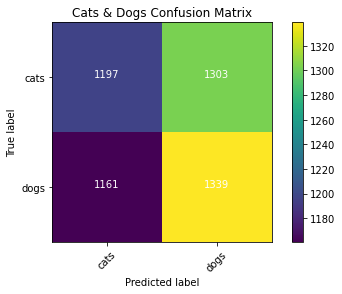

In [ ]:
plt.figure()
plot_confusion_matrix(cm, classes=["cats", "dogs"],
                      title='Cats & Dogs Confusion Matrix')
plt.show()

From what we see, our model is having an **overfitting** Problem that needs to be fixed. Or **Fine-Tuned** CNNs model.

## Build Fine-Tuned VGG16 model

**Fined-Tuned** is 

> *Transfer learning occurs when we use knowledge that was gained from solving one problem and apply it to a new but related problem.* [Deeplizard –  Introducing fine-tuning and transfer learning](https://deeplizard.com/learn/video/5T-iXNNiwIs)

- The only pre-processing we do which subtracting the mean RGB value, computed on the training set, from each pixel.

- Example:
  + The model computes the mean <span style='color:red'>red</span> value pixels from all the train data, once the model has all the total mean <span style='color:red'>red</span> value among all the training set – every <span style='color:red'>red</span> pixels in the image, the model substract it from the mean red value of the total train set.


In [11]:
# Download model – Internet connection needed
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 4s 0us/step


In [12]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
# Now let's check the type of this vgg16_model
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

This model is a type of **Functional model** which is not **Sequential model**. (we're going to discuss that, later) 

What we're looking for is, transfer the prediction layer of the imported model from 1,000 classes into 2 classes [cats, dogs]. So, we need to build a new model to change the output. 

In [14]:
model = Sequential()
for layers in vgg16_model.layers[:-1]:
  model.add(layers)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

Now, we got rid of th last layer! (a.k.a prediction layer)

Now, let's **freeze** the trainable layers of getting their *weights* and *biases* to be changed.

This means that these prameters in layers will not be changed when we start training the model using [cats, dogs].

- The reason of freezing this model weights and bias is the similarity between this model and the our model of [cats, dogs]. So that, we don't need to rebuild or model.

In [16]:
for layer in model.layers:
  layer.trainable = False

In [17]:
# Let's add our output layer for this model
model.add(Dense(units=2, activation='softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

If you notice,

- Total Trainable parameters is only including **8,194** of our last input.

- On the other hand, total **Freezed** parameters not to be trained is **134,260,544**.

## Train the Fine-Tuned VGG16 model

In [19]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
1750/1750 - 5556s - loss: 0.0771 - accuracy: 0.9762 - val_loss: 0.0418 - val_accuracy: 0.9856
Epoch 2/5
1750/1750 - 119s - loss: 0.0398 - accuracy: 0.9861 - val_loss: 0.0383 - val_accuracy: 0.9872
Epoch 3/5
1750/1750 - 120s - loss: 0.0338 - accuracy: 0.9882 - val_loss: 0.0374 - val_accuracy: 0.9872
Epoch 4/5
1750/1750 - 121s - loss: 0.0290 - accuracy: 0.9895 - val_loss: 0.0396 - val_accuracy: 0.9860
Epoch 5/5
1750/1750 - 121s - loss: 0.0255 - accuracy: 0.9914 - val_loss: 0.0386 - val_accuracy: 0.9868


## Predict the model

In [21]:
FT_prediction = model.predict(x=test_batches, verbose=0)

## Evaluation

In [22]:
# class labels
y_test = test_batches.classes
y_test

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [23]:
np.round(FT_prediction).reshape(-1).astype(int)

array([1, 0, 1, ..., 1, 0, 1])

In [24]:
test_batches.class_indices

{'cats': 0, 'dogs': 1}

In [25]:
f1_score(y_true=y_test, y_pred=np.argmax(FT_prediction, axis=-1))

0.9852177387135438

In [26]:
cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(FT_prediction, axis=-1))

In [32]:
classification_report(y_true=test_batches.classes, y_pred=np.argmax(FT_prediction, axis=-1))

'              precision    recall  f1-score   support\n\n           0       0.99      0.98      0.99      2500\n           1       0.98      0.99      0.99      2500\n\n    accuracy                           0.99      5000\n   macro avg       0.99      0.99      0.99      5000\nweighted avg       0.99      0.99      0.99      5000\n'

Confusion matrix, without normalization
[[2460   40]
 [  34 2466]]


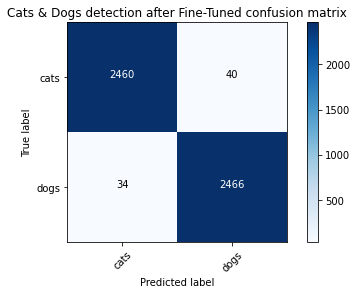

In [34]:
# Plot confusion matrix
plot_confusion_matrix(cm, classes=['cats', 'dogs'], title="Cats & Dogs detection after Fine-Tuned confusion matrix")
plt.show()

## Model Export

In [35]:
model.save("FT-Animal-Detection.h5")